(section:SAGE)=
# GraphSAGE
In this notebook, we train a GraphSAGE model with different aggregation methods.

The SAGE layer is defined as :

$X^l_u = \sigma (W^l \cdot \vert \vert (X^{l-1}_v, AGG(\{X^{l-1}_u, \forall u \in N(v)\})))$

where $\vert \vert$ is the concatenation operator and $AGG$ is a custom aggregation function. 


Specifically, we will try these for $AGG$ :
* **SumAggregation**, defined as $A^l X^{l-1}$, with $A^l$ the adjacency matrix and $X^{l-1}$ the previous layer embedding

* **MeanAggregation**, similar to GCN aside from the concatenation; where we normalize with the degree matrix, i.e. use $D^{-1} A^l X^{l-1}$ where $D$ is the degree matrix of $A^l$.

* **SquareRootAggregation**, same as above but we take the square root of the degree matrix $D$.

* **LSTMAggregation**, where we pass $A^l X^{l-1}$ through an LSTM layer that takes the features dimension of $X$ as input dimension and returns with the layer's specified output dimension.

## Training

In [1]:
from os import environ
import warnings
from sys import path

environ["WANDB_NOTEBOOK_NAME"] = "SAGE.ipynb"  # set notebook name
warnings.filterwarnings(
    "ignore"
)  # ignore warnings from missing deterministic implementation
path.append("../code")

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
from torch import nn
import numpy as np
import model as m
import training as t
import utils
import logging
import sys

from utils import LOG as logger

logging.basicConfig(
    format="%(message)s", level=logging.INFO, stream=sys.stdout
)
logger.setLevel(logging.INFO)
# logger.setLevel(logging.DEBUG)

# t.WANDB_MODE = "disabled"

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
dataloaders, dataset = t.create_dataloaders(batch_size=30)

Length of train set: 131
Length of validation set: 28
Length of test set: 29


### Model

In [5]:
node_features = dataset.node_features.shape[2]
conv_dims = [256, 256, 128, 64]
model = m.GraphSAGE(
    num_features=node_features,
    conv_dims=conv_dims,
    # fcn_layers=[128],
    activation=nn.SELU(),
    aggregation=m.LSTMAggregation(),
    dropout=0.2,
    pooling="max",
    norm=nn.BatchNorm1d,
)
# utils._print_gradient_hook(model)

print(model)

Initialized model with 4 graph conv layers
Initialized model with 1 fully connected layers
GraphSAGE(
  (convs_layers): ModuleList(
    (0): GraphSAGEConv(
      (weight): Linear(in_features=14, out_features=256, bias=False)
      (activation): SELU()
      (aggregation): LSTMAggregation(
        (lstm): LSTM(7, 7, batch_first=True)
      )
    )
    (1): GraphSAGEConv(
      (weight): Linear(in_features=512, out_features=256, bias=False)
      (activation): SELU()
      (aggregation): LSTMAggregation(
        (lstm): LSTM(256, 256, batch_first=True)
      )
    )
    (2): GraphSAGEConv(
      (weight): Linear(in_features=512, out_features=128, bias=False)
      (activation): SELU()
      (aggregation): LSTMAggregation(
        (lstm): LSTM(256, 256, batch_first=True)
      )
    )
    (3): GraphSAGEConv(
      (weight): Linear(in_features=256, out_features=64, bias=False)
      (activation): Identity()
      (aggregation): LSTMAggregation(
        (lstm): LSTM(128, 128, batch_first=Tr

### Training parameters

In [6]:
learning_rate = 1e-3
epochs = 1400

model.to(DEVICE)

label_counts = dataset.class_y.unique(return_counts=True)[1]
pos_weight = label_counts[0] / label_counts[1]


loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

history = {
    "epoch": 0,
    "loss": [],
    "acc": [],
    "val-roc": [],
    "val-ap": [],
}

### Train loop

In [7]:
history = t.train_loop(
    history=history,
    train_dataloader=dataloaders[0],
    val_dataloader=dataloaders[1],
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=epochs,
    device=DEVICE,
    use_scheduler=False,
    test_dataloader=dataloaders[2],
)

wandb: Currently logged in as: c-achard. Use `wandb login --relogin` to force relogin


Epoch   1/1400:Epoch loss: 0.3882 - avg acc: 30.5% - val-roc: 0.9286 - val-ap: 0.9458 (0.3s/epoch)
Epoch   2/1400:Epoch loss: 0.3434 - avg acc: 30.5% - val-roc: 0.8878 - val-ap: 0.8939 (0.1s/epoch)
Epoch   3/1400:Epoch loss: 0.3085 - avg acc: 42.7% - val-roc: 0.9133 - val-ap: 0.9200 (0.1s/epoch)
Epoch   4/1400:Epoch loss: 0.2333 - avg acc: 90.8% - val-roc: 0.9184 - val-ap: 0.9239 (0.1s/epoch)
Epoch   5/1400:Epoch loss: 0.2223 - avg acc: 44.3% - val-roc: 0.7704 - val-ap: 0.7481 (0.1s/epoch)
Epoch   6/1400:Epoch loss: 0.2244 - avg acc: 33.6% - val-roc: 0.8622 - val-ap: 0.8669 (0.1s/epoch)
Epoch   7/1400:Epoch loss: 0.1718 - avg acc: 70.2% - val-roc: 0.8980 - val-ap: 0.8880 (0.1s/epoch)
Epoch   8/1400:Epoch loss: 0.2359 - avg acc: 71.8% - val-roc: 0.8878 - val-ap: 0.8753 (0.1s/epoch)
Epoch   9/1400:Epoch loss: 0.1723 - avg acc: 83.2% - val-roc: 0.8827 - val-ap: 0.8668 (0.1s/epoch)
Epoch  10/1400:Epoch loss: 0.1752 - avg acc: 64.9% - val-roc: 0.8418 - val-ap: 0.8384 (0.1s/epoch)
Epoch  11/

epoch_loss,█▄▄▃▆▂▁▁▁▃▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
test/test_ap,▁
test/test_roc,▁
train_acc,▁▆▇▇▅████▇█████████▇███████████▇████████
train_loss,█▅▁▁▁▁▁▁▁█▁▁▁▁▃▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁
val/val_ap,▁▄▁▄▃▇▆▅▇▄▃▅▄▄▃▄▅▄▅▃█▄▅▆▃▅█▅▆▄▄▂▄▄▅▅▅▅▆▆
val/val_roc,▃▆▃▅▃▇▅▅█▆▅▆▆▅▄▆█▅▆▆█▅▅▅▃▄▇▆▇▅▄▁▅▅▅▆▆▆▆▆
epoch_loss,0.00069
test/test_ap,0.95348
test/test_roc,0.87778
train_acc,100.0


### Plots of training history

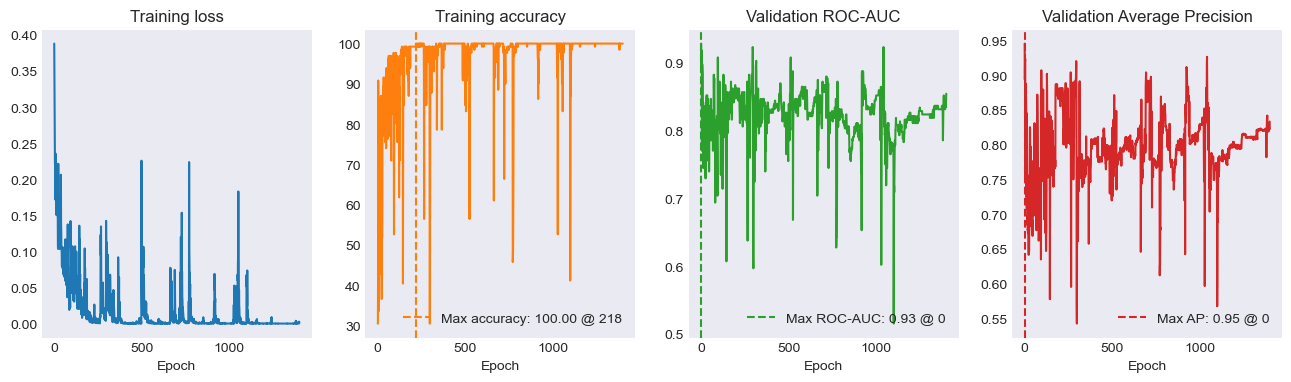

In [8]:
utils.plot_history(history)

In [ ]:
utils.show_preds_distribution(preds, ys)

In [ ]:
utils.plot_confusion_matrix(preds, ys)

In [ ]:
mislabeled = utils.find_mislabeled_molecules(preds, ys.astype(int))
print(f"{len(mislabeled)} mislabeled molecules")
mols = []
for id_mol in mislabeled:
    mols.append(full_dataset[id_mol])

thresh_preds = np.where(preds > 0.5, 1, 0)[mislabeled]
utils.draw_molecule_from_dict(
    mols[:20],
    preds=thresh_preds,
    mol_ids=mislabeled,
    n_cols=4,
    n_rows=5,
    figsize=(8, 10),
)

## Validation on unseen data

Test ROC-AUC: 0.8778
Test AP: 0.9535


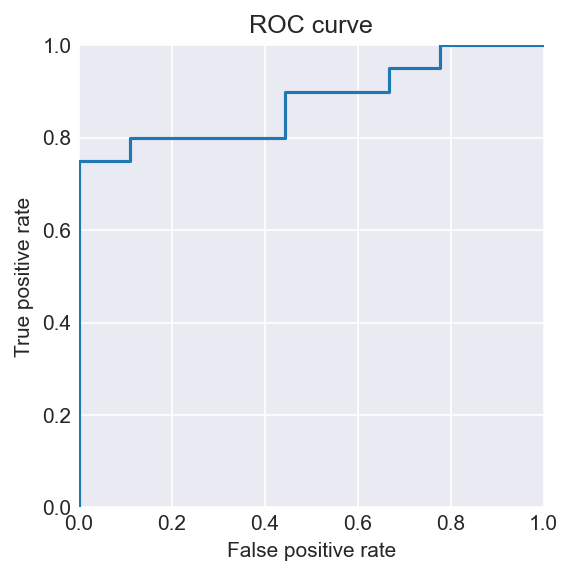

Number of correct positive predictions on test set: 16 out of 20
Number of correct negative predictions on test set: 5 out of 9


In [9]:
test_roc, test_ap, preds, ys = t.test(
    dataloaders[2].dataset, model, return_preds=True
)
print(f"Test ROC-AUC: {test_roc:.4f}")
print(f"Test AP: {test_ap:.4f}")

# Plot the ROC curve
fig = t.plot_roc_curve(dataloaders[2].dataset, model)
print(
    f"Number of correct positive predictions on test set: {torch.sum((preds > 0.5) & (ys == 1)).numpy()} out of {torch.sum(ys == 1).numpy()}"
)
print(
    f"Number of correct negative predictions on test set: {torch.sum((preds < 0.5) & (ys == 0)).numpy()} out of {torch.sum(ys == 0).numpy()}"
)

## Full dataset performance

In [10]:
data_all = t.create_dataset_dict(add_edge_features=True)
full_dataset = t.MutagDataset(data_all)

### Full ROC curve

Full ROC-AUC: 0.9676
Full AP: 0.9767


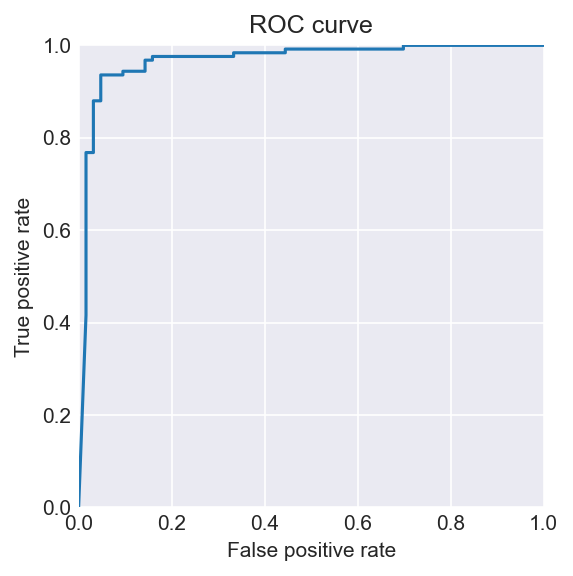

Number of correct positive predictions on test set: 118 out of 125
Number of correct negative predictions on test set: 55 out of 63


In [11]:
full_roc, full_ap, preds, ys = t.test(dataset, model, return_preds=True)
print(f"Full ROC-AUC: {full_roc:.4f}")
print(f"Full AP: {full_ap:.4f}")

# Plot the ROC curve
fig = t.plot_roc_curve(dataset, model)

preds = preds.cpu().detach().numpy()
ys = ys.cpu().detach().numpy()
print(
    f"Number of correct positive predictions on test set: {np.sum((preds > 0.5) & (ys == 1))} out of {np.sum(ys == 1)}"
)
print(
    f"Number of correct negative predictions on test set: {np.sum((preds < 0.5) & (ys == 0))} out of {np.sum(ys == 0)}"
)

### Predictions distribution

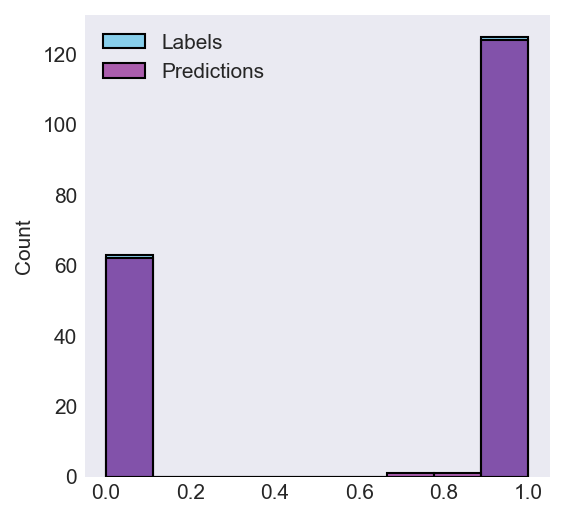

This plot shows the distribution of the labels and predictions; predictions are overlayed on top of the labels, showing whether they are missing or surnumerous.
The labels are 125 positive and 63 negative.
The predictions are 126 positive and 62 negative.


In [12]:
utils.show_preds_distribution(preds, ys)

### Confusion matrix

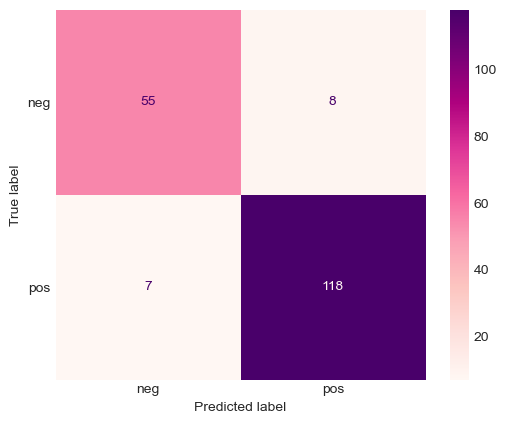

In [13]:
utils.plot_confusion_matrix(preds, ys)

### Check mislabelled molecules

15 mislabeled molecules


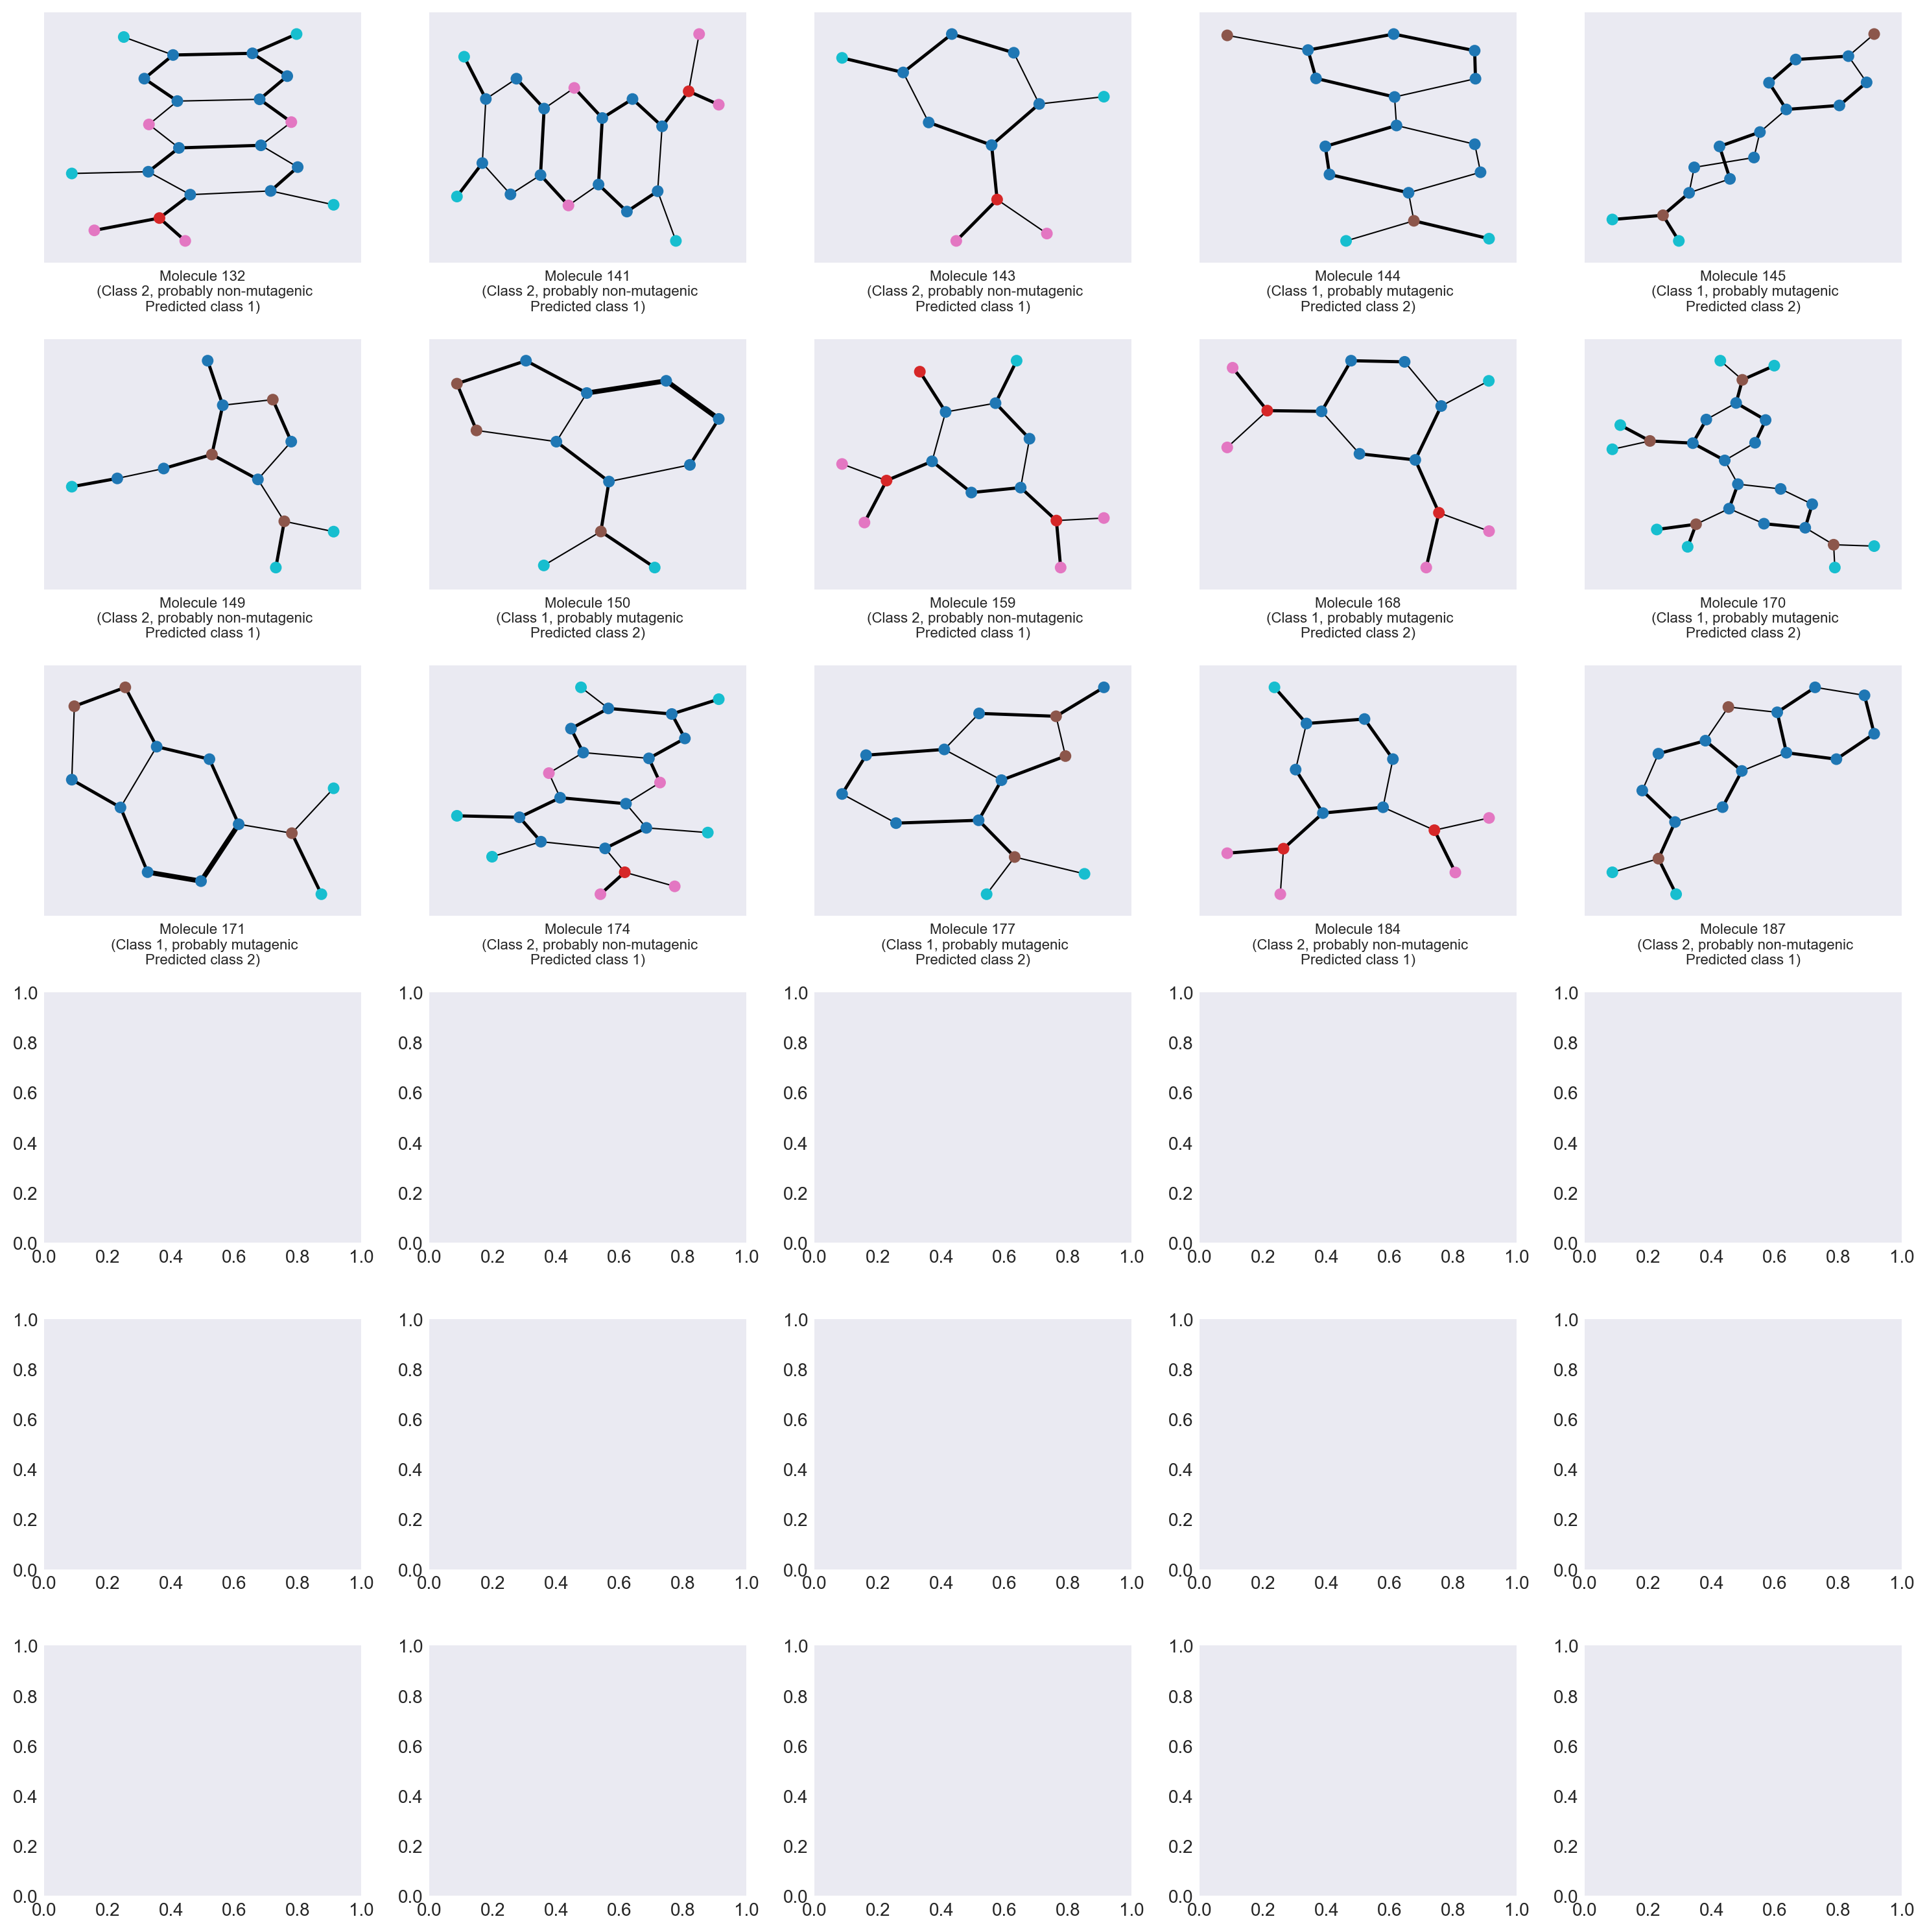

In [14]:
mislabeled = utils.find_mislabeled_molecules(preds, ys.astype(int))
print(f"{len(mislabeled)} mislabeled molecules")
mols = []
for id_mol in mislabeled:
    mols.append(full_dataset[id_mol])

thresh_preds = np.where(preds > 0.5, 1, 0)[mislabeled]
utils.draw_molecule_from_dict(
    mols[:30],
    preds=thresh_preds,
    mol_ids=mislabeled,
    n_cols=5,
    n_rows=6,
    figsize=(15, 15),
)